<a href="https://colab.research.google.com/github/Dhanush7-8/Fake-News-Detection-Using-BERT/blob/main/Copy_of_11_16_group_2_fake_news_detection_using_bert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install transformers

In [2]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D,Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.python.ops.numpy_ops import np_utils
from transformers import BertModel, TFBertModel
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from transformers import BertTokenizer, TFBertModel
from tensorflow.keras import regularizers
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [3]:
import pandas as pd
from matplotlib import rcParams
import seaborn as sns
import numpy as np
from PIL import Image
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from transformers import AutoTokenizer

In [11]:
fake_data = pd.read_csv("/content/News Dataset/Fake.csv", engine='python')
real_data = pd.read_csv("/content/News Dataset/True.csv", engine='python')

In [12]:
fake_data.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [44]:
real_data.head()

,title,text,subject,date,label
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",real
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",real
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",real
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",real
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",real


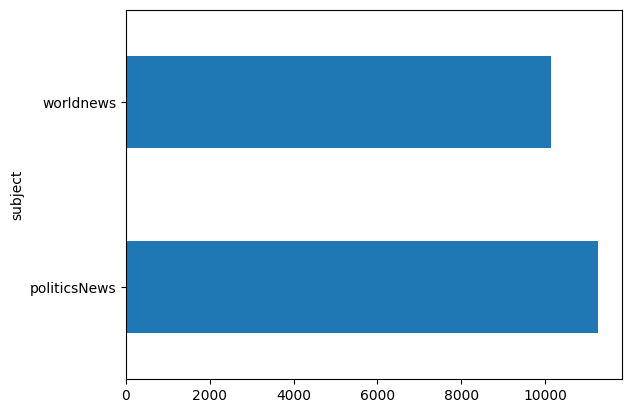

In [45]:
real_data['subject'].value_counts().plot(kind='barh')
rcParams['figure.figsize'] = 5,5

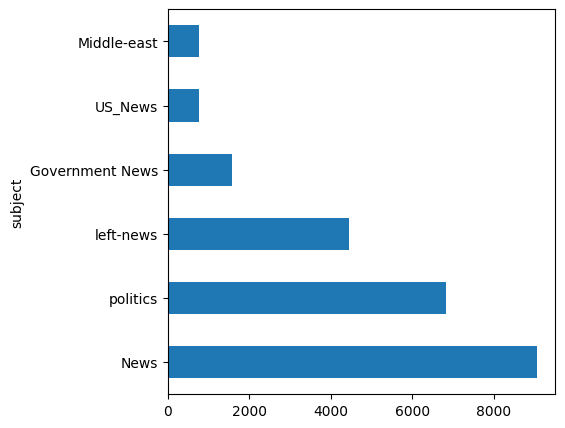

In [46]:
fake_data['subject'].value_counts().plot(kind='barh')
rcParams['figure.figsize'] = 5,5

WORLDCLOUD REAL TEXT DATA

In [47]:
wordcld_mask=np.array(Image.open("/content/News Dataset/twitter.png"))

In [48]:
wordcld_text=" ".join(real_data["text"].tolist())

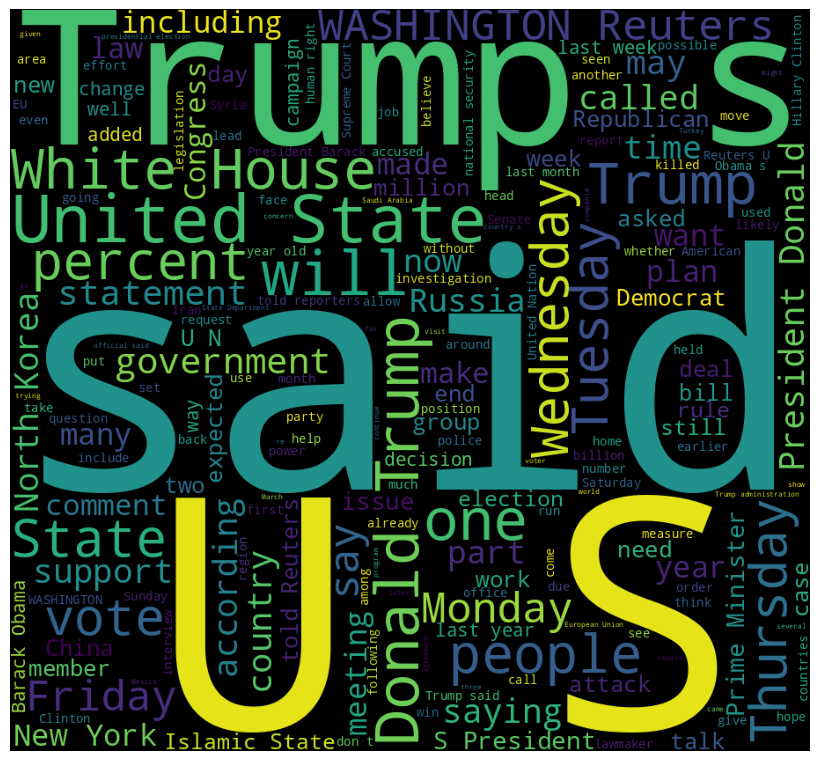

In [49]:
wordcloud=WordCloud(width=1920,height=1080,mask=wordcld_mask).generate(wordcld_text)
fig=plt.figure(figsize=(8,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

WORLDCLOUD FAKE TEXT DATA

In [50]:
fake_text=" ".join(fake_data["text"].tolist())

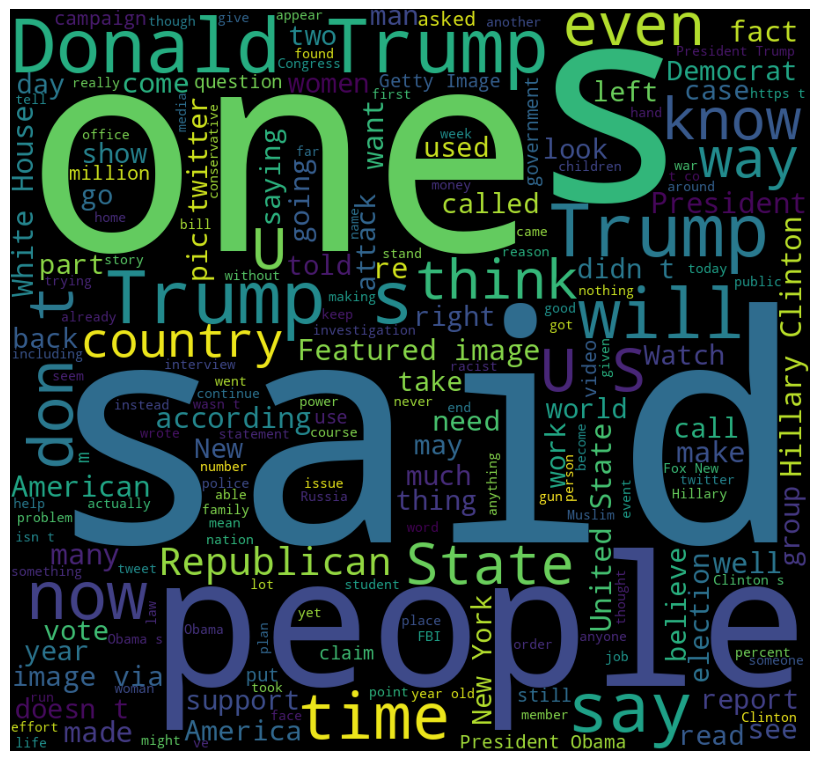

In [51]:
wordcloud=WordCloud(width=1920,height=1080,mask=wordcld_mask).generate(fake_text)
fig=plt.figure(figsize=(8,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

In [52]:
fake_data["label"]="fake"
real_data["label"]="real"

In [14]:
final_data= pd.concat([fake_data,real_data])


In [15]:
final_data = final_data.sample(frac=1).reset_index(drop=True)

In [53]:
final_data.head(10)

,title,text,subject,date,label,source_credibility,sources_detected
0,Kurdish leaders reject Baghdad demand to cance...,BAGHDAD (Reuters) - Iraq s Kurdish leadership ...,worldnews,"October 15, 2017",real,0.95,[reuters.com]
1,Navy SEAL Tells Katy Perry: “Go to H*ll” [Video],Navy SEAL Carl Higbie had three words for Katy...,politics,"May 26, 2017",fake,0.70,"[cnn.com, foxnews.com]"
2,"Florida stations face fuel shortages, delays a...",NEW YORK (Reuters) - Gasoline stations around ...,worldnews,"September 6, 2017",real,0.95,[reuters.com]
3,PRICELESS! DONALD TRUMP Joined By The Ladies O...,I want everybody to know that we stand behind...,politics,"Dec 5, 2015",fake,0.25,[]
4,Rival sides square off over succession at U.S....,WASHINGTON (Reuters) - A battle over who shoul...,politicsNews,"November 27, 2017",real,0.95,"[reuters.com, cnn.com]"
5,MIZZOU Cry-Babies Complain Paris Terror Traged...,Never mind that almost every single aspect of ...,left-news,"Nov 14, 2015",fake,0.15,[breitbart.com]
6,Iraqi Kurds say Baghdad will pay heavy price f...,BAGHDAD (Reuters) - Iraq s Kurdish security fo...,worldnews,"October 16, 2017",real,0.95,[reuters.com]
7,Ballet Dancing Great Who Defected From Soviet...,Mikhail Baryshnikov is one of the greatest bal...,News,"August 17, 2016",fake,0.25,[]
8,HILARIOUS! LIBERALS STUNNED When Republican Gu...,"On Saturday, MSNBC s Joy Reid repeatedly attem...",left-news,"Feb 19, 2017",fake,0.25,[]
9,Factbox - Department of Labor retirement 'fidu...,(Reuters) - The U.S. Department of Labor plans...,politicsNews,"April 6, 2016",real,0.95,[reuters.com]


# SOURCE CREDIBILITY

In [43]:
import re

# weights given to the credibility of the news source. Higher is more trustworthy, lower is more likelihood of fake
source_trust = {
    'reuters.com': 0.95,
    'apnews.com': 0.95,
    'bbc.com': 0.95,
    'npr.org': 0.90,
    'nytimes.com': 0.85,
    'washingtonpost.com': 0.85,
    'foxnews.com': 0.65,
    'cnn.com': 0.70,
    'dailymail.co.uk': 0.50,
    'infowars.com': 0.10,
    'breitbart.com': 0.15,
    'theonion.com': 0.05,
    'naturalnews.com': 0.10,
}

source_mapping = {
    'reuters': 'reuters.com',
    'associated press': 'apnews.com',
    'ap news': 'apnews.com',
    'bbc': 'bbc.com',
    'cnn': 'cnn.com',
    'fox news': 'foxnews.com',
    'new york times': 'nytimes.com',
    'washington post': 'washingtonpost.com',
    'npr': 'npr.org',
    'bloomberg': 'bloomberg.com',
    'usa today': 'usatoday.com',
    'wall street journal': 'wsj.com',
    'the guardian': 'theguardian.com',
    'al jazeera': 'aljazeera.com',
    'daily mail': 'dailymail.co.uk',
    'dailymail': 'dailymail.co.uk',
    'infowars': 'infowars.com',
    'breitbart': 'breitbart.com',
    'the onion': 'theonion.com',
    'natural news': 'naturalnews.com',
}

# Patterns for matching keywords from news text
patterns = {
    'reuters': r'\(reuters\)|\breuters\b',
    'associated press': r'\(associated press\)|\bassociated press\b',
    'ap news': r'\(ap\)\s*-|\bap\s+news\b',  # Only (AP) - or "AP News"
    'bbc': r'\(bbc\)|\bbbc\b',
    'cnn': r'\(cnn\)|\bcnn\b',
    'fox news': r'\(fox news\)|\bfox news\b',
    'new york times': r'\(new york times\)|\bnew york times\b',
    'washington post': r'\(washington post\)|\bwashington post\b',
    'npr': r'\(npr\)|\bnpr\b',
    'bloomberg': r'\(bloomberg\)|\bbloomberg\b',
    'usa today': r'\(usa today\)|\busa today\b',
    'wall street journal': r'\(wall street journal\)|\bwall street journal\b',
    'the guardian': r'\(the guardian\)|\bthe guardian\b',
    'al jazeera': r'\(al jazeera\)|\bal jazeera\b',
    'daily mail': r'\(daily mail\)|\bdaily mail\b',
    'dailymail': r'\(dailymail\)|\bdailymail\b',
    'infowars': r'\(infowars\)|\binfowars\b',
    'breitbart': r'\(breitbart\)|\bbreitbart\b',
    'the onion': r'\(the onion\)|\bthe onion\b',
    'natural news': r'\(natural news\)|\bnatural news\b',
}

"Find news source from the text"
def source_extraction(text):
    text = str(text)

    domains_found = []

    for source_name, pattern in patterns.items():
        if re.search(pattern, text, re.IGNORECASE):
            domains_found.append(source_mapping[source_name])

    return list(set(domains_found))

"""Set credibility based on source"""
def get_credibility(text, label=None):
    domains = source_extraction(text)

    scores = []
    for domain in domains:
        if domain in source_trust:
            scores.append(source_trust[domain])

    if scores:
        return max(scores), domains
    else:
        # If no sources detected but it's real news, give medium credibility
        if label == 'real':
            return 0.5, domains  # Medium credibility for real news without detected sources
        else:
            return 0.25, domains  # Low credibility for fake/news without detected sources

"Apply extraction to entire dataset"
credibility_scores = []
sources_detected = []

for idx, text in enumerate(final_data['text']):
    label = final_data.iloc[idx]['label']  # Get the label for this row
    score, sources = get_credibility(text, label)
    credibility_scores.append(score)
    sources_detected.append(sources)

final_data['source_credibility'] = credibility_scores
final_data['sources_detected'] = sources_detected

print("\nApplying extraction to entire dataset...")

# Analyze the results
def analyze_results(df):
    # Credibility distribution comparison
    print(f"\nCredibility Distribution (New Method):")
    high_cred = df[df['source_credibility'] >= 0.8]
    med_cred = df[(df['source_credibility'] >= 0.5) & (df['source_credibility'] < 0.8)]
    low_cred = df[df['source_credibility'] < 0.5]

    print(f"  High credibility (≥0.8): {len(high_cred)} articles")
    print(f"  Medium credibility (0.5-0.8): {len(med_cred)} articles")
    print(f"  Low credibility (<0.5): {len(low_cred)} articles")

"""Compare how extraction handles real vs fake news"""
def compare_real_vs_fake(df):
    real_news = df[df['label'] == 'real']  # Adjust based on your actual label values
    fake_news = df[df['label'] == 'fake']

    print("\n" + "=" * 60)
    print("REAL vs FAKE NEWS DETECTION")
    print("=" * 60)

    # Average credibility scores
    print(f"\nAverage credibility scores:")
    print(f"  Real news: {real_news['source_credibility'].mean():.3f}")
    print(f"  Fake news: {fake_news['source_credibility'].mean():.3f}")

    # Detection accuracy
    real_correct = (real_news['source_credibility'] >= 0.5).mean()
    fake_correct = (fake_news['source_credibility'] < 0.5).mean()

    print(f"\nDetection accuracy:")
    print(f"  Real news correctly identified (≥0.5): {real_correct:.1%}")
    print(f"  Fake news correctly identified (<0.5): {fake_correct:.1%}")

# Run all analyses
analyze_results(final_data)
compare_real_vs_fake(final_data)
final_data


Applying extraction to entire dataset...

Credibility Distribution (New Method):
  High credibility (≥0.8): 23987 articles
  Medium credibility (0.5-0.8): 3599 articles
  Low credibility (<0.5): 17312 articles

REAL vs FAKE NEWS DETECTION

Average credibility scores:
  Real news: 0.949
  Fake news: 0.377

Detection accuracy:
  Real news correctly identified (≥0.5): 100.0%
  Fake news correctly identified (<0.5): 73.7%


,title,text,subject,date,label,source_credibility,sources_detected
0,Kurdish leaders reject Baghdad demand to cance...,BAGHDAD (Reuters) - Iraq s Kurdish leadership ...,worldnews,"October 15, 2017",real,0.95,[reuters.com]
1,Navy SEAL Tells Katy Perry: “Go to H*ll” [Video],Navy SEAL Carl Higbie had three words for Katy...,politics,"May 26, 2017",fake,0.70,"[cnn.com, foxnews.com]"
2,"Florida stations face fuel shortages, delays a...",NEW YORK (Reuters) - Gasoline stations around ...,worldnews,"September 6, 2017",real,0.95,[reuters.com]
3,PRICELESS! DONALD TRUMP Joined By The Ladies O...,I want everybody to know that we stand behind...,politics,"Dec 5, 2015",fake,0.25,[]
4,Rival sides square off over succession at U.S....,WASHINGTON (Reuters) - A battle over who shoul...,politicsNews,"November 27, 2017",real,0.95,"[reuters.com, cnn.com]"
...,...,...,...,...,...,...,...
44893,"In the Age of Amazon, Are Traditional Shopping...","USA Meg Mall in Seattle, WA (Source: Bynyalcin...",Middle-east,"July 5, 2017",fake,0.25,[bloomberg.com]
44894,Protesters storm Kurdistan parliament after Ba...,"BAGHDAD (Reuters) - Demonstrators, some carryi...",worldnews,"October 29, 2017",real,0.95,[reuters.com]
44895,The DEA Will Deliver Some Big News About Mari...,The Drug Enforcement Agency released a 25-page...,News,"April 7, 2016",fake,0.25,[]
44896,Malawi ministers to testify against cabinet co...,LILONGWE (Reuters) - Three Malawian ministers ...,worldnews,"September 18, 2017",real,0.95,[reuters.com]


In [ ]:
final_data.isnull().sum()

In [ ]:
final_data.drop(["subject","date"], axis=1)

In [ ]:
final_data.head(20)

In [ ]:
final_data.label.value_counts()

In [ ]:
sns.set_theme(style="whitegrid")
sns.countplot(x=final_data["label"])

In [ ]:
final_data.head(5)

In [ ]:
final_data["text"]=final_data["title"]+final_data["text"]

In [ ]:
final_data=final_data[["text","label", "fact_score"]]

In [ ]:
final_data['label'] = final_data['label'].map({'real':1, 'fake':0})

In [ ]:
final_data.sample(5)

In [ ]:
final_data.label[9943]

In [ ]:
final_data.text[36709]

In [ ]:
max_len=100
data_text=final_data["text"]
data_label=final_data["label"]

In [ ]:
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

In [ ]:
pip install safetensors


In [ ]:
from transformers import BertModel, AutoTokenizer
bert_model = TFBertModel.from_pretrained('bert-base-uncased', use_safetensors=False)
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')


In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(data_text, data_label, stratify = data_label, test_size = 0.2, random_state =42)

In [ ]:
def tokenize(X):

    X = bert_tokenizer(
        text = list(X),
        add_special_tokens = True,
        max_length = 100,
        truncation = True,
        padding = 'max_length',
        return_tensors = 'tf',
        return_token_type_ids = False,
        return_attention_mask = True,
        verbose = True
        )
    return X

In [ ]:
X_train_token = tokenize(X_train)
X_test_token = tokenize(X_test)

In [ ]:
maxlen=100

**BERT MODEL CREATION**

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, Layer
from tensorflow.keras.models import Model

class BertLayer(tf.keras.layers.Layer):
    def __init__(self, bert_model, **kwargs):
        super(BertLayer, self).__init__(**kwargs)
        self.bert = bert_model

    def call(self, inputs):
        # Ensure inputs are tensors (Keras may sometimes pass tf.Tensor, sometimes lists/arrays)
        input_ids = tf.convert_to_tensor(inputs['input_ids'])
        attention_mask = tf.convert_to_tensor(inputs['attention_mask'])
        outputs = self.bert({'input_ids': input_ids, 'attention_mask': attention_mask})
        return outputs.pooler_output

    def compute_output_shape(self, input_shape):
        # Set the output shape based on the BERT pooler output size
        return (input_shape['input_ids'][0], self.bert.config.hidden_size)

def create_model(bert_model, maxlen=100):
    input_ids = Input(shape=(maxlen,), dtype=tf.int32, name='input_ids')
    attention_mask = Input(shape=(maxlen,), dtype=tf.int32, name='attention_mask')
    bert_layer = BertLayer(bert_model)
    pooled_output = bert_layer({'input_ids': input_ids, 'attention_mask': attention_mask})
    x = Dropout(0.5)(pooled_output)
    x = Dense(64, activation='tanh')(x)
    x = Dropout(0.5)(x)
    output = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=[input_ids, attention_mask], outputs=output)
    return model


In [ ]:
model = create_model(bert_model)

In [ ]:
optimizer = Adam(learning_rate=1e-5, epsilon=1e-8, clipnorm=1.0)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss',  # or another metric you want to monitor
    patience=3,  # number of epochs with no improvement after which training will be stopped
    restore_best_weights=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,  # Reduce the learning rate by a factor of 0.1
    patience=3,  # Number of epochs with no improvement to wait before reducing the learning rate
    verbose=1,
    min_lr=1e-6  # Minimum learning rate
)

In [ ]:
import numpy as np
X_train_token['input_ids'] = np.array(X_train_token['input_ids'])
X_train_token['attention_mask'] = np.array(X_train_token['attention_mask'])
X_test_token['input_ids'] = np.array(X_test_token['input_ids'])
X_test_token['attention_mask'] = np.array(X_test_token['attention_mask'])

In [ ]:
from transformers import TFBertModel
bert_model = TFBertModel.from_pretrained('bert-base-uncased', use_safetensors=False)


In [ ]:
history = model.fit(
    x={
        'input_ids': X_train_token['input_ids'],
        'attention_mask': X_train_token['attention_mask']
    },
    y=Y_train,
    epochs=20,
    batch_size=30,
    validation_data=(
        {
            'input_ids': X_test_token['input_ids'],
            'attention_mask': X_test_token['attention_mask']
        },
        Y_test
    ),
    callbacks=[early_stopping, reduce_lr]
)

Accuracy History

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Loss History

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Making Predictions

In [ ]:
y_pred_proba = model.predict({
    'input_ids': X_test_token['input_ids'],
    'attention_mask': X_test_token['attention_mask']
})

# Convert probabilities to binary predictions
y_pred = np.where(y_pred_proba >= 0.5, 1, 0)

Confusion Matrix

In [ ]:
from mlxtend.plotting import plot_confusion_matrix
conf_matrix = confusion_matrix(Y_test,y_pred)
fig, ax = plot_confusion_matrix(conf_mat=conf_matrix, figsize=(6, 6), cmap=plt.cm.Greens)
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [ ]:
print(classification_report(Y_test,y_pred))

In [ ]:
from sklearn.metrics import roc_curve, auc


y_pred_prob = model.predict(
    {
        'input_ids': X_test_token['input_ids'],
        'attention_mask': X_test_token['attention_mask']
    }
)

fpr, tpr, thresholds = roc_curve(Y_test, y_pred_prob)  # Removed indexing on y_pred_prob
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10,8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
from sklearn.metrics import precision_recall_curve, auc


y_pred_prob = model.predict(
    {
        'input_ids': X_test_token['input_ids'],
        'attention_mask': X_test_token['attention_mask']
    }
)

precision, recall, thresholds = precision_recall_curve(Y_test, y_pred_prob)
pr_auc = auc(recall, precision)

plt.figure(figsize=(10,8))
plt.plot(recall, precision, color='b', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score


y_pred_prob = model.predict(
    {
        'input_ids': X_test_token['input_ids'],
        'attention_mask': X_test_token['attention_mask']
    }
)
pred = (y_pred_prob > 0.5).astype(int)

accuracy = accuracy_score(Y_test, pred)

plt.plot([])
plt.text(0, 0, f'Accuracy Score: {accuracy:.4f}', fontsize=16, ha='center', va='center', color="indigo")
plt.axis('off')
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.show()

In [ ]:
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

y_pred_prob = model.predict(
    {
        'input_ids': X_test_token['input_ids'],
        'attention_mask': X_test_token['attention_mask']
    }
)
roc_auc = roc_auc_score(Y_test, y_pred_prob)

plt.plot([])
plt.text(0, 0, f'ROC AUC Score: {roc_auc:.4f}', fontsize=16, ha='center', va='center', color="indigo")
plt.axis('off')
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.show()

In [ ]:
from sklearn.metrics import cohen_kappa_score, matthews_corrcoef, brier_score_loss
import matplotlib.pyplot as plt

# Assuming you have `y_pred_prob` for predicted probabilities and `Y_test` for true labels
pred = (y_pred_prob > 0.5).astype(int)

cohen_kappa = cohen_kappa_score(Y_test, pred)
matthews_corr = matthews_corrcoef(Y_test, pred)
brier_score = brier_score_loss(Y_test, y_pred_prob)

# Plot Cohen's Kappa Score
plt.plot([])
plt.text(0, 0, f'Cohen\'s Kappa Score: {cohen_kappa:.4f}', fontsize=16, ha='center', va='center', color="indigo")
plt.axis('off')
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.show()

In [ ]:
plt.plot([])
plt.text(0, 0, f'Matthews Correlation Coefficient: {matthews_corr:.4f}', fontsize=16, ha='center', va='center', color="indigo")
plt.axis('off')
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.show()

In [ ]:
plt.plot([])
plt.text(0, 0, f'Brier Score Loss: {brier_score:.4f}', fontsize=16, ha='center', va='center', color="indigo")
plt.axis('off')
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.show()

In [ ]:
from sklearn.metrics import log_loss
import matplotlib.pyplot as plt

log_loss_value = log_loss(Y_test, y_pred_prob)

plt.plot([])
plt.text(0, 0, f'Log Loss: {log_loss_value:.4f}', fontsize=16, ha='center', va='center', color="indigo")
plt.axis('off')
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.show()

**CUSTOM DATA PREDICTION**

In [ ]:
test_text="Cop Shares Racist Meme About Michelle Obama; Now That Cop Is Having A VERY Bad Day (IMAGES)After the election of Donald Trump many folks seem to see it as a permission slip to be as racist and vile as possible. However, here s the thing, you re still going to get called out as racist and vile. And one Alabama police officer just found this out the hard way.According to the Washington Post: Talladega Police Officer Joel Husk was terminated Wednesday for violating the department s social media and code of conduct policies, City Manager Patrick Bryant said. What did he do? So glad you asked: Husk had posted several memes on his Facebook page, including one showing Obama and Melania Trump.  Fluent in Slovenian, English, French, Serbian, and German,  it said over Trump s photo. Over Obama s, it read:  Fluent in Ghetto. Not only that, he posted several extraordinarily racist memes:via Washington Postvia Washington PostAccording to the City Manager, the statements were  deemed to be biased or racially insensitive or derogatory  and because of that, they  have to take action to correct it. If you re going to be a police officer and serve all the public, you can t assume black people standing up for their rights are equivalent to the KKK. That s about the most horrific equivalence imaginable.Also, according to WaPo: Husk, 37, who had been with the department for about two and a half years, had also shared a meme showing President Obama with the words:  Was Dallas a terrorist attack? Yes! Carried out by Obama s own homegrown terrorist group! Which is a blatant lie and anyone who were to feel that way belongs nowhere near law enforcement. The city took the proper action letting this racist cop go, and hopefully it will be an example to police departments all over the country that this sort of behavior simply cannot be tolerated.Trump s election must not be allowed to serve as a permission slip to bigots everywhere that it s fine to be as awful as possible, because here in the land of the free and the home of the brave, everyone is protected. Everyone, regardless of color, class, gender, sexual orientation, or creed.Featured Photo by Chip Somodevilla/Getty Images'"

In [ ]:
test_token = tokenize(test_text)

In [ ]:
test_text_pred = np.where(model.predict({
    'input_ids' : test_token['input_ids'],
    'attention_mask' : test_token['attention_mask']
}) >= 0.5, 1, 0)

In [ ]:
test_text_pred

In [ ]:
if(test_text_pred[0]==0):
    print("News is Fake")
else:
    print("News is Real")